# S2S RNN to predict next state

We aim to predict the next steps on time series

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [4]:
import import_ipynb

import Process_Training_Data_2

from Process_Training_Data_2 import norm
from Process_Training_Data_2 import denorm
from Process_Training_Data_2 import class_to_action
from Process_Training_Data_2 import closest_category

importing Jupyter notebook from Process_Training_Data_2.ipynb
      id_camino         D0         D1        D2   D3   D4   D5       A0   A1
0             0  85.591116  -9.250073 -4.257165  0.0  0.0  0.0 -0.05236  0.0
15            1  98.043500 -37.779358 -4.257165  0.0  0.0  0.0 -0.03491  0.0
25            2  91.272922 -36.852284 -4.257165  0.0  0.0  0.0 -0.00000  0.0
34            3  94.839433  -8.007799 -4.257165  0.0  0.0  0.0 -0.05236  0.0
52            4  69.791783 -31.305606 -4.257165  0.0  0.0  0.0 -0.00000  0.0
...         ...        ...        ...       ...  ...  ...  ...      ...  ...
2042        235  41.074009 -34.144254 -4.257165  0.0  0.0  0.0 -0.00000  0.0
2048        236  40.754941 -11.474966 -4.257165  0.0  0.0  0.0 -0.00000  0.0
2054        237  36.542365 -20.220654 -4.257165  0.0  0.0  0.0 -0.00000  0.0
2059        238  77.290122 -11.950868 -4.257165  0.0  0.0  0.0 -0.03491  0.0
2072        239  38.729629 -32.034013 -4.257165  0.0  0.0  0.0 -0.00000  0.0

[240 rows x 9

### Get the data
First Import it using pandas

In [7]:
dataset_short = Process_Training_Data_2.get_data("./data/OSPA_training_data 2.csv")

action_vector = ["A0","A1"]
normed_dataset = Process_Training_Data_2.normalize_data(dataset_short,action_vector)

N_STEPS = 8
position = "post"
dataset2 = Process_Training_Data_2.padding(normed_dataset,N_STEPS,position)

In [8]:
training_size = len(dataset2)
training_size 

240

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [11]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, prediction_type):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, history_size)
    data.append(dataset[i,indices,:])

    if prediction_type is "single_step":
      labels.append(target[i,history_size + target_size])
    elif prediction_type is "multiple_step":
      labels.append(target[i,history_size:history_size+target_size])
    elif prediction_type  is "sequence":
      labels.append(target[i, 1:history_size + 1])   

  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [12]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
past_history = N_STEPS
future_target = 0
STEP = N_STEPS+1
prediction_type ="sequence"
features_dataset = dataset2
target_dataset = dataset2[:,:,6:8]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT, past_history, future_target, STEP, prediction_type)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None, past_history, future_target, STEP, prediction_type)

In [13]:
x_train_single_sequential[0]

array([[ 3.42252418, -0.86058386, -1.04955781,  0.        ,  0.        ,
         0.        , -0.05236   ,  0.        ],
       [ 3.23278355, -0.7448705 , -1.45831509, -2.48326035,  0.611125  ,
         0.18785338, -0.10472   ,  0.        ],
       [ 2.9820536 , -0.67263644, -1.475209  , -3.23867716, -0.63976405,
        -0.98865374, -0.        ,  0.        ],
       [ 2.75571624, -0.61537664, -1.55879942, -1.62269157,  0.76949209,
         1.15680282, -0.08727   ,  0.        ],
       [ 2.48240517, -0.50128583, -1.69716933, -2.99318575, -0.41263161,
        -1.06054554, -0.03491   ,  0.        ],
       [ 2.22951858, -0.50159523, -1.48938638, -2.2492868 ,  0.0083015 ,
         0.49667227, -0.        ,  0.        ],
       [ 1.9735024 , -0.3140465 , -1.9794522 , -1.22302987,  1.17856698,
         0.81604813, -0.10472   ,  0.        ],
       [ 1.65373063, -0.2511935 , -1.75498629, -3.20621792, -1.22588537,
        -1.7133891 , -0.01745   ,  0.        ]])

In [14]:
print ('Single window of past history : {}'.format(x_train_single_sequential[0].shape))

Single window of past history : (8, 8)


In [27]:
y_train_single_sequential[0]

array([[-0.10472,  0.     ],
       [-0.     ,  0.     ],
       [-0.08727,  0.     ],
       [-0.03491,  0.     ],
       [-0.     ,  0.     ],
       [-0.10472,  0.     ],
       [-0.01745,  0.     ],
       [-0.08727,  0.     ]])

In [16]:
BATCH_SIZE = 20
# BUFFER_SIZE = 10000

train_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_train_single_sequential, y_train_single_sequential))
train_data_single_sequential = train_data_single_sequential.cache().batch(BATCH_SIZE).repeat()

val_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_val_single_sequential, y_val_single_sequential))
val_data_single_sequential = val_data_single_sequential.batch(BATCH_SIZE).repeat()

### Build the model

In [17]:
single_step_sequential_model = tf.keras.models.Sequential()
single_step_sequential_model.add(tf.keras.layers.LSTM(11,return_sequences=True, input_shape=(None, 8)))
single_step_sequential_model.add(tf.keras.layers.Dense(2, activation='linear'))

single_step_sequential_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse', metrics=['mse','mae'])

### Inspect the model

In [18]:
single_step_sequential_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 11)          880       
_________________________________________________________________
dense (Dense)                (None, None, 2)           24        
Total params: 904
Trainable params: 904
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [19]:
STEPS_PER_EPOCH = training_size / BATCH_SIZE
EPOCHS = 20

single_step_sequential_history = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_single_sequential, validation_steps=50)

Train for 12.0 steps, validate for 50 steps
Epoch 1/20
12/12 [==============================] - 7s 558ms/step - loss: nan - mse: nan - mae: nan - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 2/20
12/12 [==============================] - 0s 26ms/step - loss: nan - mse: nan - mae: nan - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 3/20
12/12 [==============================] - 0s 24ms/step - loss: nan - mse: nan - mae: nan - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 4/20
12/12 [==============================] - 0s 21ms/step - loss: nan - mse: nan - mae: nan - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 5/20
12/12 [==============================] - 0s 29ms/step - loss: nan - mse: nan - mae: nan - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 6/20
12/12 [==============================] - 0s 27ms/step - loss: nan - mse: nan - mae: nan - val_loss: nan - val_mse: nan - val_mae: nan
Epoch 7/20
12/12 [==============================] - 0s 30ms/step - loss: nan - mse: n

Compute the accuracy

In [20]:
N_CATEGORIES = 28
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [21]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [23]:
test_loss, test_mse, test_mae = single_step_sequential_model.evaluate(x_val_single_sequential,  y_val_single_sequential, verbose=2)

48/48 - 0s - loss: nan - mse: nan - mae: nan


Visualize the model's training progress.

In [43]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

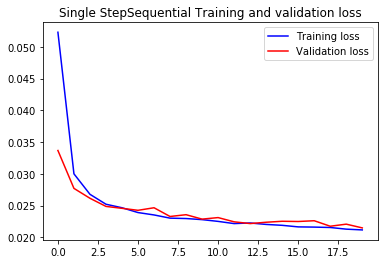

In [44]:
plot_train_history(single_step_sequential_history,
                   'Single StepSequential Training and validation loss')

#### Adding early stop

In [45]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single_sequential,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0211,  mae:0.0211,  mse:0.0011,  val_loss:0.0221,  val_mae:0.0221,  val_mse:0.0012,  
....................

In [46]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states() 

0.47272727


In [47]:
single_step_sequential_model.save('./data/single_step_sequential_model.h5') 